In [2]:
import torch
import os
import re

In [3]:
def read_time_machine():
    path = os.getcwd() + "/data/TimeMachine"
    with open(path + "/book.txt") as f:
        return f.read()
    
def preprocess(text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

def tokenize(text):
    return text.split(" ")
book = read_time_machine()
processed_text = preprocess(book)
tokenised_text = tokenize(processed_text)

In [92]:
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
class CustomTimeMachineLoader(Dataset):
    def __init__(self, seq_length, tokens):
        super().__init__()
        self.tokens = tokens
        self.tokens_to_index = {k : v for v,k in enumerate(sorted(set(['<unk>'] + tokens)))}
        self.index_to_token = {k : v for v,k in self.tokens_to_index.items()}
        self.seq_length = seq_length
        self.vocab_size = len(self.tokens_to_index)

    def __getitem__(self, idx):
        sample = [self.tokens_to_index.get(self.tokens[idx * self.seq_length + i], self.tokens_to_index['<unk>']) for i in range(self.seq_length)]
        target = [self.tokens_to_index.get(self.tokens[idx * self.seq_length + i + 1], self.tokens_to_index['<unk>']) for i in range(self.seq_length)]
        sample_tensor = torch.tensor(sample, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)
        one_hot_sample = F.one_hot(sample_tensor, num_classes=self.vocab_size).float()
        one_hot_target = F.one_hot(target_tensor, num_classes=self.vocab_size).float()
        return one_hot_sample, one_hot_target

    def __len__(self): 
        return len(self.tokens) // self.seq_length - 2

In [26]:
full_data = CustomTimeMachineLoader(seq_length=5, tokens=tokenised_text)
train_ratio = 0.8
train_data, test_data = random_split(full_data, [train_ratio, 1-train_ratio])

In [27]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

## Distribution Analysis

Text(0.5, 1.0, 'Log-Log Word Frequencies')

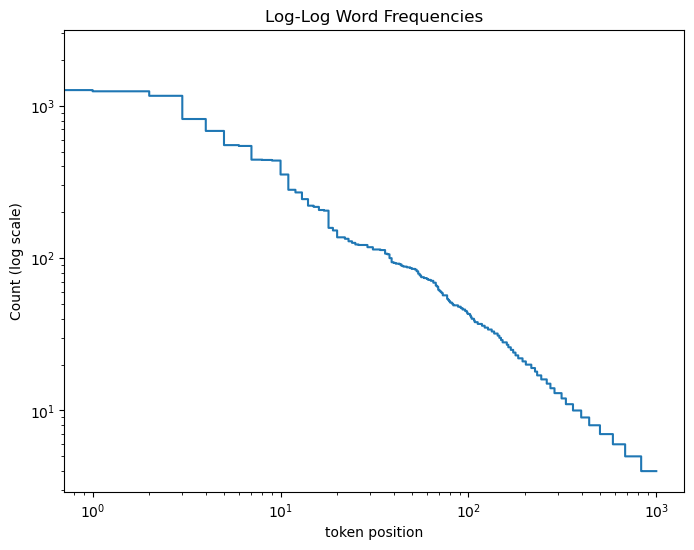

In [9]:
import matplotlib.pyplot as plt
from collections import Counter
frequency = Counter(tokenised_text)
top_10 = frequency.most_common(1000)
words_top, counts_top = zip(*top_10)
# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.step(range(len(words_top)), counts_top)
# Set the y-axis ogarithmic scale
plt.yscale('log')
plt.xscale('log')
plt.ylabel("Count (log scale)")
plt.xlabel("token position")
plt.title("Log-Log Word Frequencies")


Shows a distribution of words with frequencies known as Zipf's law, which states that the frequency $n_i$ of the $i^{th}$ most common word is: 
$$n_i \propto \frac{1}{i^\alpha}$$

which is equivalent to: 
$$ log(n_i) = -\alpha log(i) + c $$

Let's see if this holds for bi-grams and tri-grams as well.

In [10]:
bigram = [(tokenised_text[i], tokenised_text[i+1]) for i in range(0, len(tokenised_text), 2)]
frequency_bi = Counter(bigram)
top_10 = frequency_bi.most_common(1000)
words_top_bi, counts_top_bi = zip(*top_10)

In [11]:
trigram = [(tokenised_text[i], tokenised_text[i+1], tokenised_text[i+2]) for i in range(0, len(tokenised_text)-1, 3)]
frequency_tri = Counter(trigram)
top_10 = frequency_tri.most_common(1000)
words_top_tri, counts_top_tri = zip(*top_10)

Text(0.5, 0, 'token position')

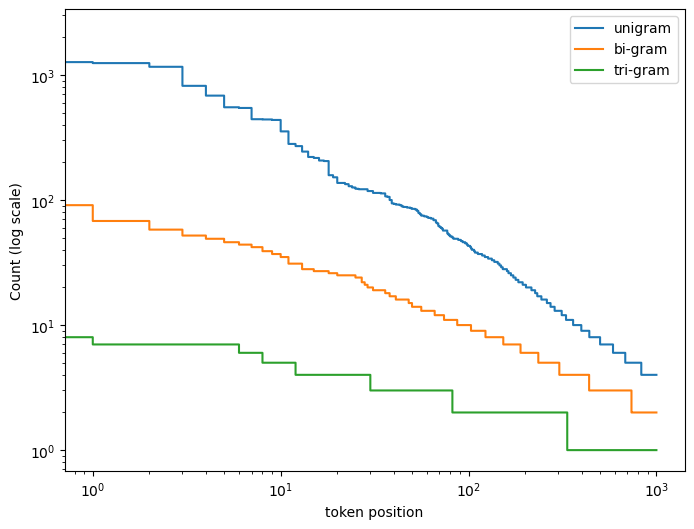

In [12]:
# Create a bar plot
plt.figure(figsize=(8, 6))
plt.step(range(len(words_top)), counts_top)
plt.step(range(len(words_top_bi)), counts_top_bi)
plt.step(range(len(words_top_tri)), counts_top_tri)

plt.legend(['unigram', 'bi-gram', 'tri-gram'])
# Set the y-axis ogarithmic scale
plt.yscale('log')
plt.xscale('log')
plt.ylabel("Count (log scale)")
plt.xlabel("token position")

## GRUs

In [79]:
from torch import nn
class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        # For the update gate
        self.W_z = nn.Parameter(torch.empty(input_size, hidden_size))
        self.U_z = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.b_z = nn.Parameter(torch.zeros(hidden_size))
        
        # For the reset gate
        self.W_r = nn.Parameter(torch.empty(input_size, hidden_size))
        self.U_r = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.b_r = nn.Parameter(torch.zeros(hidden_size))
        
        # For the candidate hidden state
        self.W_h = nn.Parameter(torch.empty(input_size, hidden_size))
        self.U_h = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

        ## For the output state
        self.W_o = nn.Linear(hidden_size, vocab_size)
        # Initialize weights
        for param in [self.W_z, self.U_z, self.W_r, self.U_r, self.W_h, self.U_h]:
            nn.init.xavier_normal_(param)


    def forward_h(self, x, h0):
        # x: (B, input_size), h0: (B, hidden_size)
        zt = torch.sigmoid(x @ self.W_z + h0 @ self.U_z + self.b_z)
        rt = torch.sigmoid(x @ self.W_r + h0 @ self.U_r + self.b_r)
        ht = torch.tanh(x @ self.W_h + (rt * h0) @ self.U_h + self.b_h)
        htf = (1 - zt) * h0 + zt * ht
        return htf
    
    def forward(self, x, h0=None):
        B,T, _ = x.size()
        if h0 is None:
            h  = torch.zeros(B, self.hidden_size, device=x.device)
        else: 
            h = h0            

        outputs = []
        for t in range(T):
            h = self.forward_h(x[:, t, :], h)
            logits = self.W_o(h)
            outputs.append(logits.unsqueeze(1))
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [82]:
full_data = CustomTimeMachineLoader(seq_length=3, tokens=tokenised_text)
train_ratio = 0.8
train_data, test_data = random_split(full_data, [train_ratio, 1-train_ratio])

In [83]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [84]:
gru = CustomGRU(input_size=full_data.vocab_size, hidden_size=10, vocab_size=(full_data.vocab_size))

In [85]:
from tqdm import tqdm
optimiser = torch.optim.Adam(gru.parameters(), lr=0.001)
num_epochs = 100
losses = []
test_losses = []
for epoch in tqdm(range(num_epochs)):
    loss_sum = 0.0 
    count = 0
    gru.train()
    for seq, yo in train_dataloader:
        target_indices = yo.argmax(dim=-1)  # now shape: (B, T)
        logits = gru(seq)
        loss = nn.CrossEntropyLoss()(logits.view(-1, full_data.vocab_size), target_indices.view(-1))
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        loss_sum += loss.item()
        count += 1
    
    losses.append(loss_sum / count)
    gru.eval()
    loss_sum = 0.0 
    count = 0

    with torch.no_grad():
        for seq, yo in test_dataloader:
            target_indices = yo.argmax(dim=-1)  # now shape: (B, T)
            logits = gru(seq)
            loss = nn.CrossEntropyLoss()(logits.view(-1, full_data.vocab_size), target_indices.view(-1))
            loss_sum += loss.item()
            count += 1
    test_losses.append(loss_sum / count)


100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


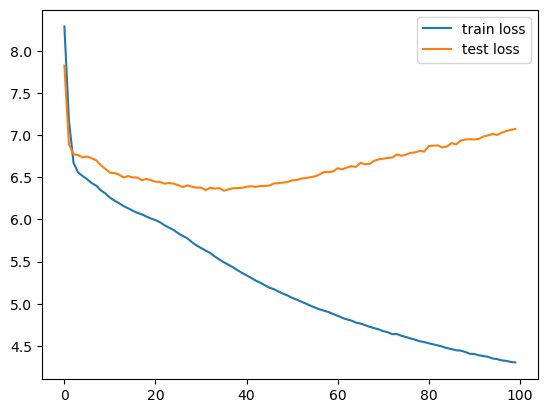

In [89]:
plt.plot(losses[:])
plt.plot(test_losses[:])
plt.legend(['train loss', 'test loss'])

## Experiments

In [162]:
def get_train_test_loader(seq_length=3, train_ratio=0.8):
    full_data = CustomTimeMachineLoader(seq_length=seq_length, tokens=tokenised_text)
    train_data, test_data = random_split(full_data, [train_ratio, 1-train_ratio])
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
    return train_dataloader, test_dataloader



def train_test_loop(model, optimiser, num_epochs, train_dataloader, test_dataloader, custom_model=True, Wo=None):
    losses = []
    test_losses = []
    for _ in tqdm(range(num_epochs)):
        loss_sum = 0.0 
        count = 0
        model.train()
        for seq, yo in train_dataloader:
            target_indices = yo.argmax(dim=-1)  # now shape: (B, T)
            if custom_model:
                logits = model(seq)
            else: 
                hn, _ = model(seq)
                logits = Wo(hn)
            loss = nn.CrossEntropyLoss()(logits.view(-1, full_data.vocab_size), target_indices.view(-1))
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            loss_sum += loss.item()
            count += 1
        
        losses.append(loss_sum / count)

        model.eval()
        loss_sum = 0.0 
        count = 0
        with torch.no_grad():
            for seq, yo in test_dataloader:
                target_indices = yo.argmax(dim=-1)  # now shape: (B, T)
                if custom_model:
                    logits = model(seq)
                else: 
                    hn, _ = model(seq)
                    logits = Wo(hn)
                loss = nn.CrossEntropyLoss()(logits.view(-1, full_data.vocab_size), target_indices.view(-1))
                loss_sum += loss.item()
                count += 1
        test_losses.append(loss_sum / count)
    return model, losses, test_losses

### Sequence Lengths

In [126]:
data = {}
for i in [2,3,4, 5,6, 7,8, 9]:
    train_loader, test_loader = get_train_test_loader(seq_length=i)
    gru = CustomGRU(input_size=full_data.vocab_size, hidden_size=10, vocab_size=(full_data.vocab_size))
    optimiser = torch.optim.Adam(gru.parameters(), lr=0.001)
    trained_model, train_loss, test_loss = train_test_loop(gru, optimiser, 100, train_loader, test_loader)
    data[i] = (trained_model, train_loss, test_loss)

100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


Text(0.5, 1.0, 'Test Loss vs Seq Length')

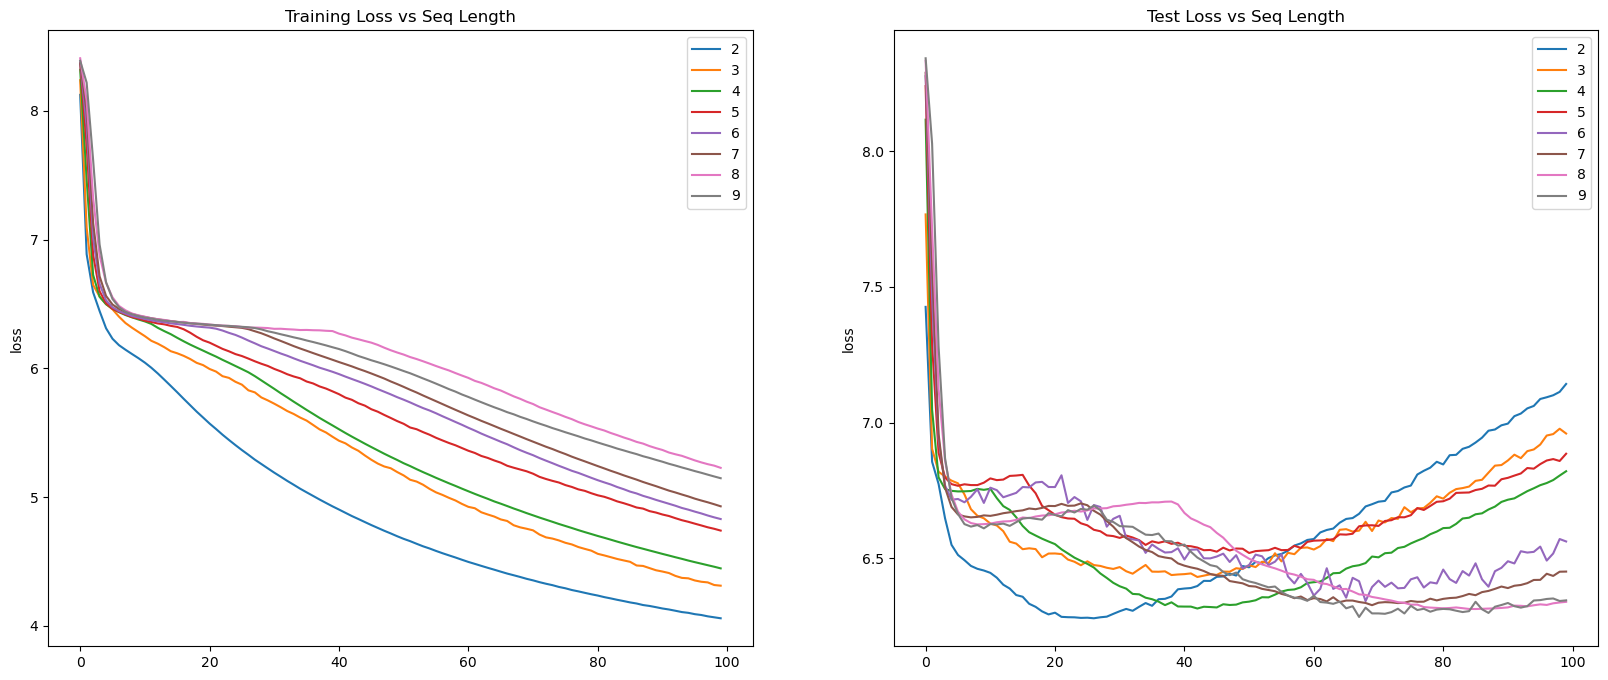

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for idx, j in enumerate(list(data.values())):
    axs[0].plot(j[1], label=idx + 2)
    axs[1].plot(j[2], label=idx+2)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("loss")
axs[1].set_ylabel("loss")
axs[0].set_title("Training Loss vs Seq Length")
axs[1].set_title("Test Loss vs Seq Length")

### Hidden Size

In [128]:
data_h = {}
for i in [1, 2,3,4, 5,6, 7,8, 9, 10]:
    train_loader, test_loader = get_train_test_loader(seq_length=2)
    gru = CustomGRU(input_size=full_data.vocab_size, hidden_size=i * 10, vocab_size=(full_data.vocab_size))
    optimiser = torch.optim.Adam(gru.parameters(), lr=0.001)
    trained_model, train_loss, test_loss = train_test_loop(gru, optimiser, 50, train_loader, test_loader)
    data_h[i] = (trained_model, train_loss, test_loss)

100%|██████████| 50/50 [02:20<00:00,  2.81s/it]


Text(0.5, 1.0, 'Test Loss vs Hidden State Size')

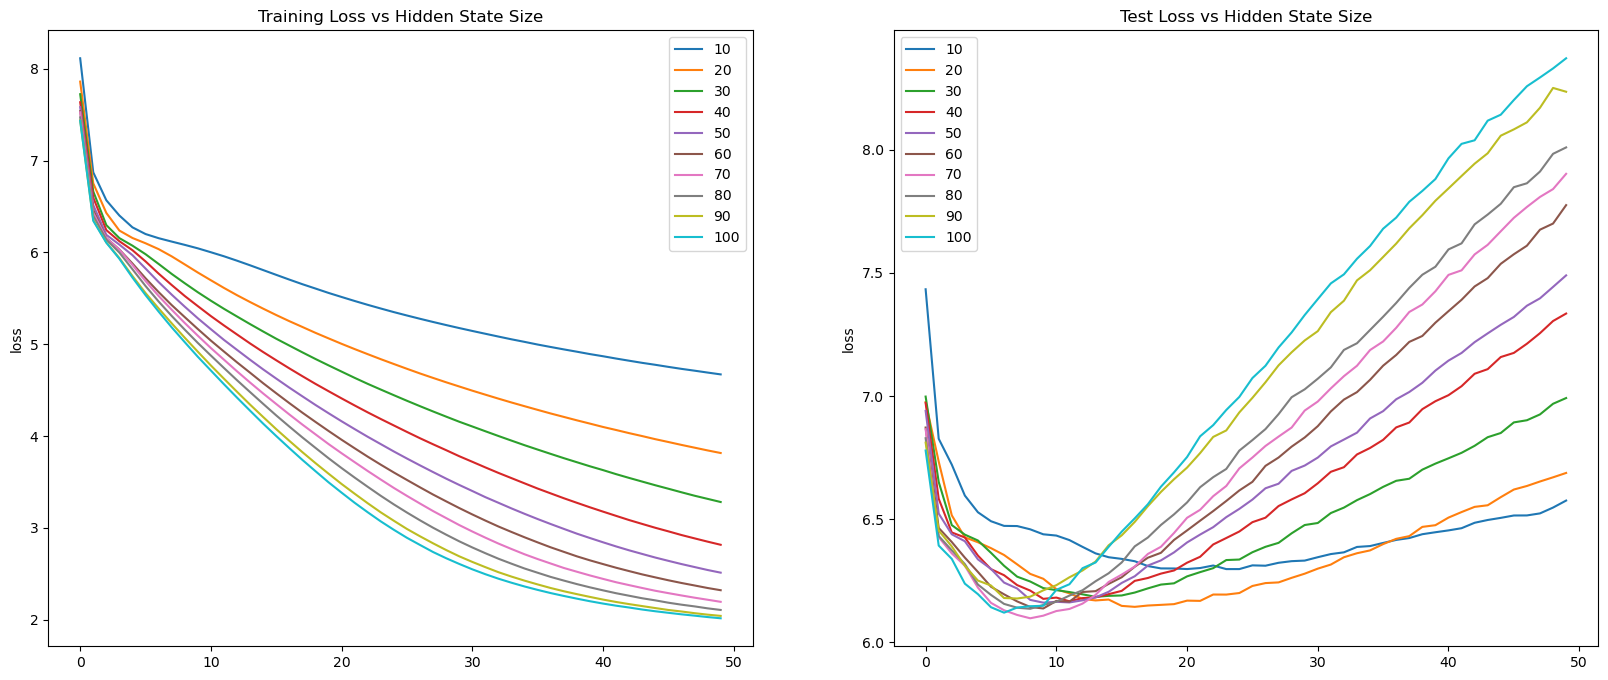

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for idx, j in enumerate(list(data_h.values())):
    axs[0].plot(j[1], label=(idx + 1) * 10)
    axs[1].plot(j[2], label=(idx + 1) * 10)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("loss")
axs[1].set_ylabel("loss")
axs[0].set_title("Training Loss vs Hidden State Size")
axs[1].set_title("Test Loss vs Hidden State Size")

### Longer Seq optimisation

In [132]:
data_h = {}
for j in [2, 5, 8]:
    for i in [1, 2,3,4, 5,6, 7,8, 9, 10]:
        train_loader, test_loader = get_train_test_loader(seq_length=j)
        gru = CustomGRU(input_size=full_data.vocab_size, hidden_size=i * 10, vocab_size=(full_data.vocab_size))
        optimiser = torch.optim.Adam(gru.parameters(), lr=0.001)
        trained_model, train_loss, test_loss = train_test_loop(gru, optimiser, 50, train_loader, test_loader)
        data_h[(j,i)] = (trained_model, train_loss, test_loss)

100%|██████████| 50/50 [02:01<00:00,  2.43s/it]


Text(0.5, 1.0, 'Test Loss vs Hidden State Size (seq_length=2)')

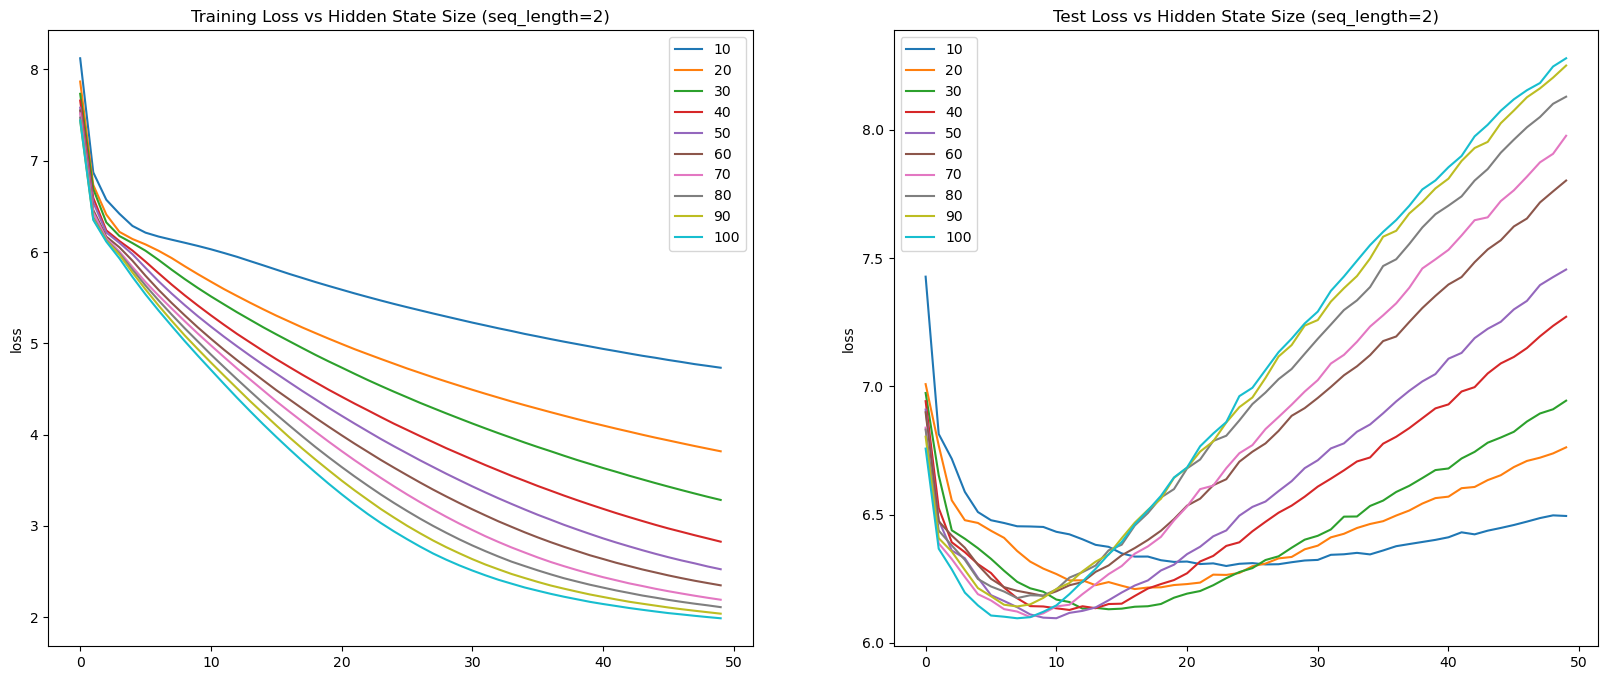

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for idx, j in enumerate([1, 2,3,4, 5,6, 7,8, 9, 10]):
    axs[0].plot(data_h[(2, j)][1], label=(idx + 1) * 10)
    axs[1].plot(data_h[(2, j)][2], label=(idx + 1) * 10)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("loss")
axs[1].set_ylabel("loss")
axs[0].set_title("Training Loss vs Hidden State Size (seq_length=2)")
axs[1].set_title("Test Loss vs Hidden State Size (seq_length=2)")

Text(0.5, 1.0, 'Test Loss vs Hidden State Size (seq_length=5)')

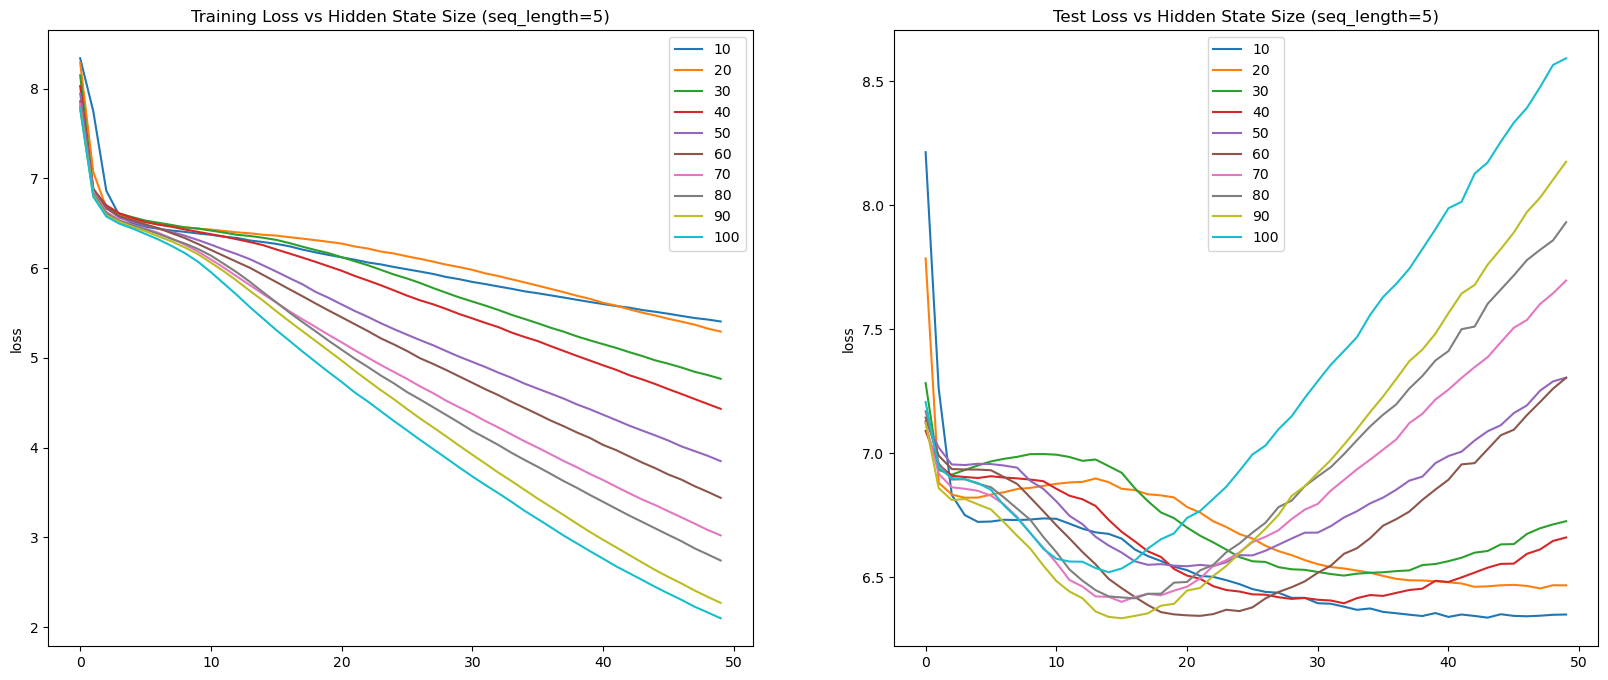

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for idx, j in enumerate([1, 2,3,4, 5,6, 7,8, 9, 10]):
    axs[0].plot(data_h[(5, j)][1], label=(idx + 1) * 10)
    axs[1].plot(data_h[(5, j)][2], label=(idx + 1) * 10)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("loss")
axs[1].set_ylabel("loss")
axs[0].set_title("Training Loss vs Hidden State Size (seq_length=5)")
axs[1].set_title("Test Loss vs Hidden State Size (seq_length=5)")

Text(0.5, 1.0, 'Test Loss vs Hidden State Size (seq_length=8)')

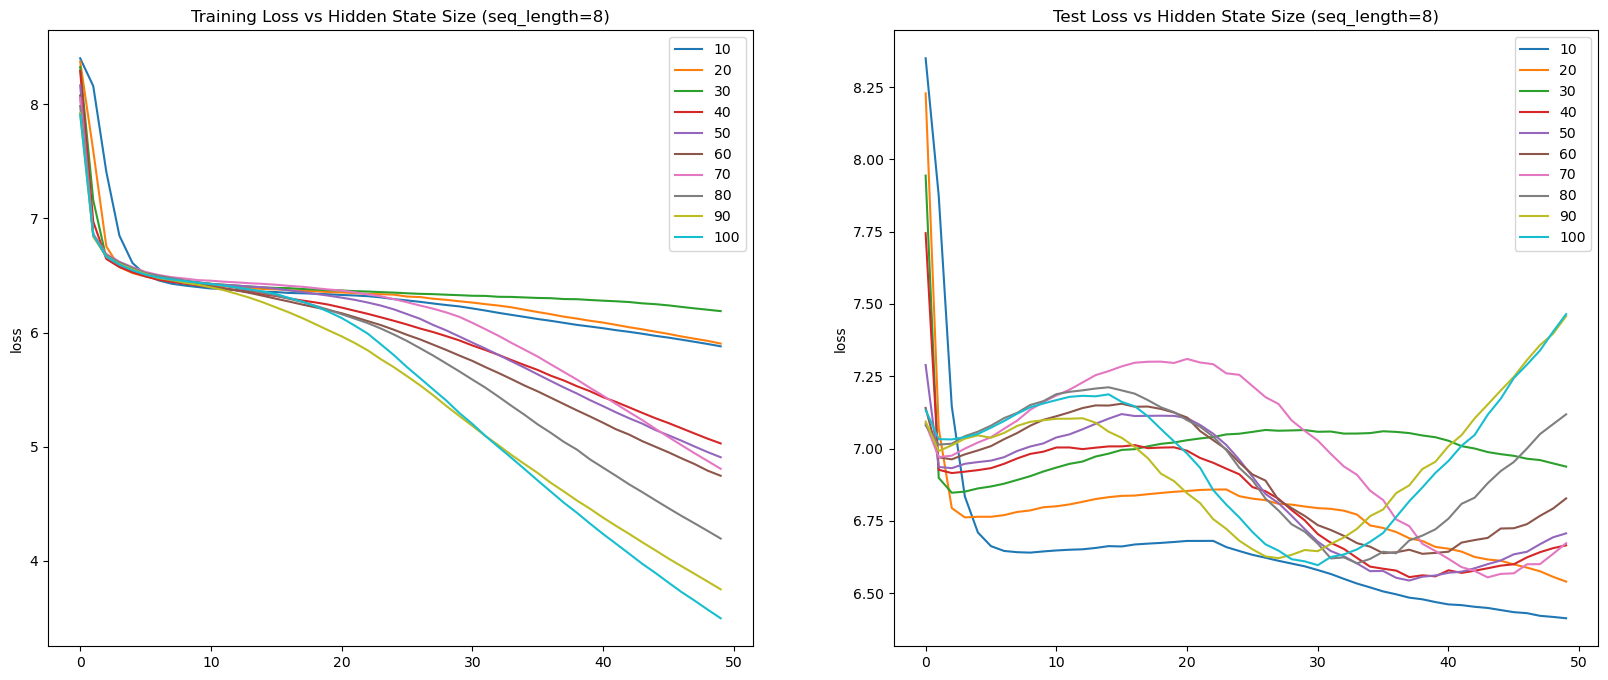

In [135]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for idx, j in enumerate([1, 2,3,4, 5,6, 7,8, 9, 10]):
    axs[0].plot(data_h[(8, j)][1], label=(idx + 1) * 10)
    axs[1].plot(data_h[(8, j)][2], label=(idx + 1) * 10)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("loss")
axs[1].set_ylabel("loss")
axs[0].set_title("Training Loss vs Hidden State Size (seq_length=8)")
axs[1].set_title("Test Loss vs Hidden State Size (seq_length=8)")

## Actual GRU Pytorch Comp

In [163]:
data_h = {}
for j in [2, 5, 8]:
    for i in [1, 2,3,4, 5,6, 7,8, 9, 10]:
        train_loader, test_loader = get_train_test_loader(seq_length=j)
        gru = nn.GRU(input_size=full_data.vocab_size, hidden_size=i * 10)
        connected_layer = nn.Linear(i * 10, full_data.vocab_size)
        optimiser = torch.optim.Adam(gru.parameters(), lr=0.001)
        trained_model, train_loss, test_loss = train_test_loop(gru, optimiser, 50, train_loader, test_loader, custom_model=False, Wo=connected_layer)
        data_h[(j,i)] = (trained_model, train_loss, test_loss)

100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


Text(0.5, 1.0, 'Test Loss vs Hidden State Size (seq_length=2)')

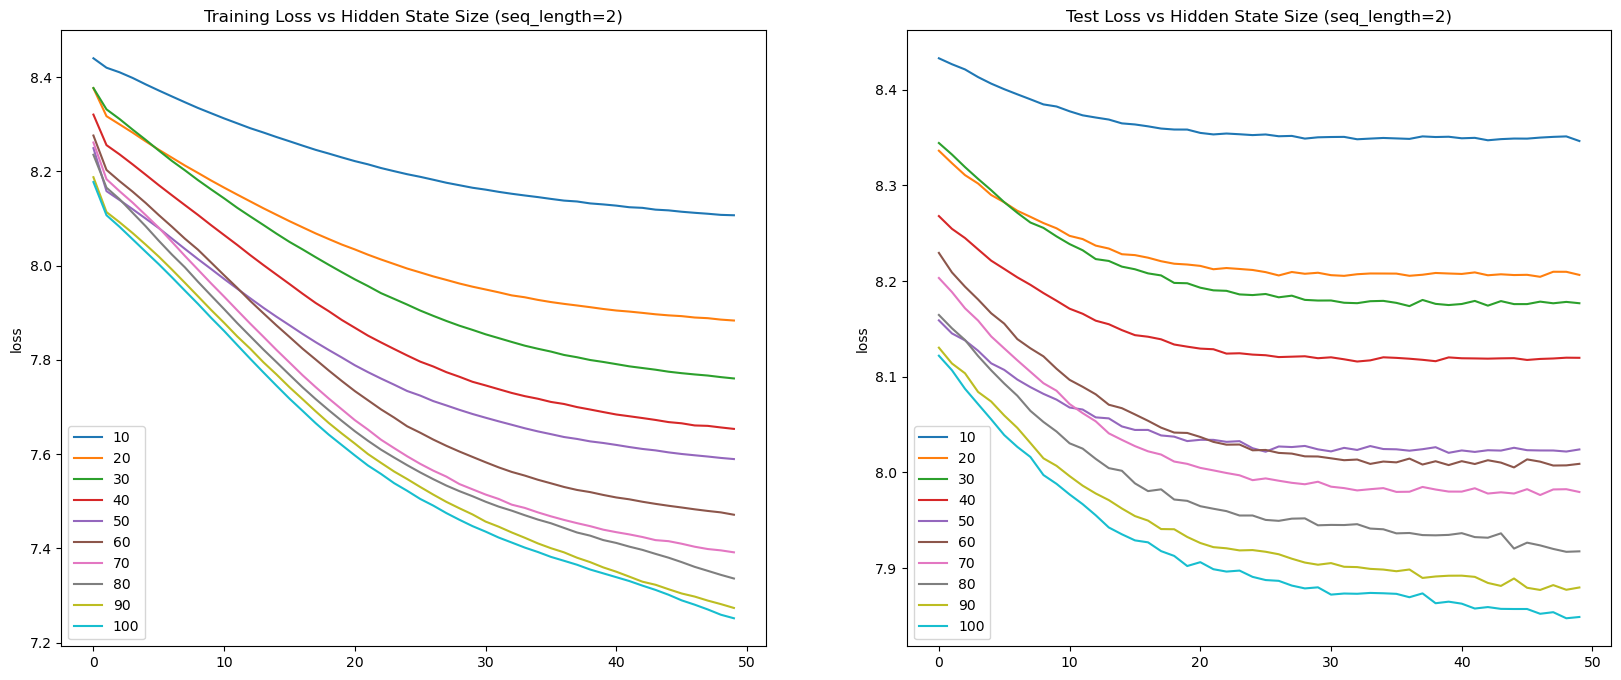

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for idx, j in enumerate([1, 2,3,4, 5,6, 7,8, 9, 10]):
    axs[0].plot(data_h[(2, j)][1], label=(idx + 1) * 10)
    axs[1].plot(data_h[(2, j)][2], label=(idx + 1) * 10)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("loss")
axs[1].set_ylabel("loss")
axs[0].set_title("Training Loss vs Hidden State Size (seq_length=2)")
axs[1].set_title("Test Loss vs Hidden State Size (seq_length=2)")

Text(0.5, 1.0, 'Test Loss vs Hidden State Size (seq_length=5)')

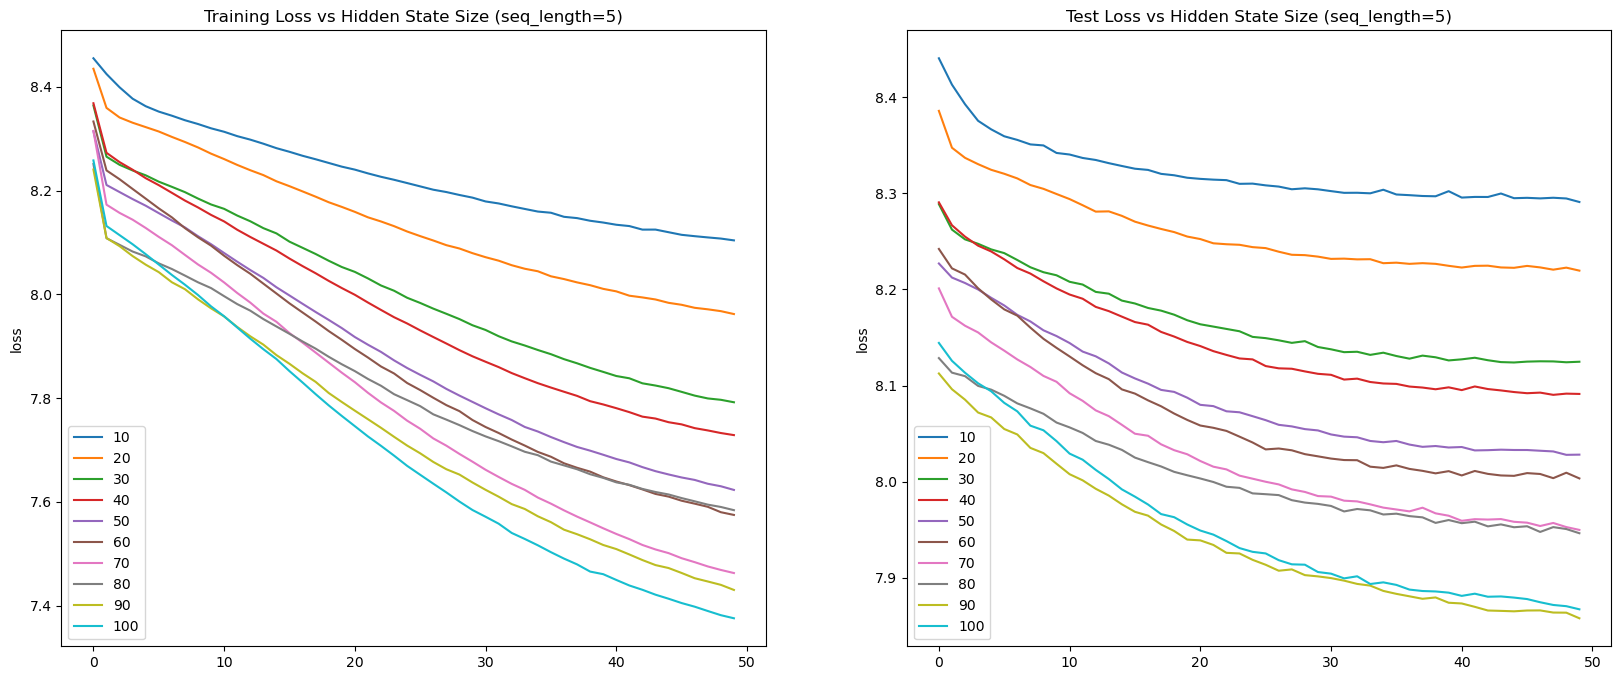

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for idx, j in enumerate([1, 2,3,4, 5,6, 7,8, 9, 10]):
    axs[0].plot(data_h[(5, j)][1], label=(idx + 1) * 10)
    axs[1].plot(data_h[(5, j)][2], label=(idx + 1) * 10)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("loss")
axs[1].set_ylabel("loss")
axs[0].set_title("Training Loss vs Hidden State Size (seq_length=5)")
axs[1].set_title("Test Loss vs Hidden State Size (seq_length=5)")

Text(0.5, 1.0, 'Test Loss vs Hidden State Size (seq_length=8)')

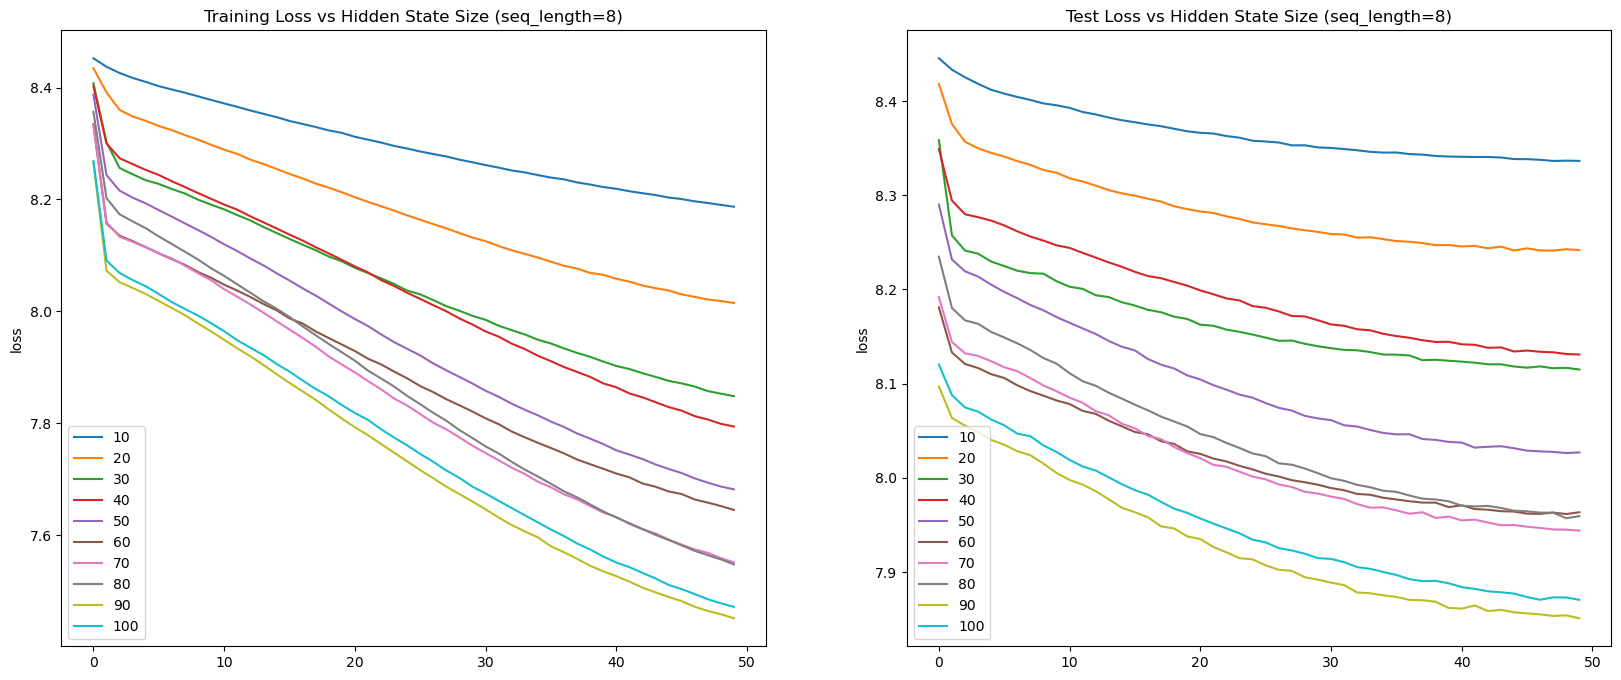

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for idx, j in enumerate([1, 2,3,4, 5,6, 7,8, 9, 10]):
    axs[0].plot(data_h[(8, j)][1], label=(idx + 1) * 10)
    axs[1].plot(data_h[(8, j)][2], label=(idx + 1) * 10)
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("loss")
axs[1].set_ylabel("loss")
axs[0].set_title("Training Loss vs Hidden State Size (seq_length=8)")
axs[1].set_title("Test Loss vs Hidden State Size (seq_length=8)")

## But Are we doing Next Token Modeling Correctly?

In [191]:
def read_sherlock():
    path = os.getcwd() + "/data/SherlockHolmes"
    with open(path + "/books.txt") as f:
        return f.read()
    
def postprocess(text):
    new = []
    for i in text:
        i = i.strip()
        if len(i) == 0:
            continue
        else:
            new.append(re.sub('[^A-Za-z]+', ' ', i).lower())
    return new

def tokenize(text):
    return text.split("\n")
book = read_sherlock()
tokenised_text = tokenize(book)
processed_text = postprocess(tokenised_text)


In [253]:
class CustomSherlockHolmesLoader(Dataset):
    def __init__(self, seq_length, lines, device=None):
        super().__init__() 
        self.tokens_to_index = {k : v + 1 for v,k in enumerate(sorted(set(['<unk>'] + " ".join(processed_text).split(" "))))}
        self.index_to_token = {k : v for v,k in self.tokens_to_index.items()}
        self.seq_length = seq_length
        self.vocab_size = len(self.tokens_to_index) + 1
        self.lines = lines
        self.embeddings = self.get_embeddings(lines)
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.max_embeddings = max([len(a) for a in self.embeddings])

    def get_embeddings(self, lines):
        embeddings = []
        for line in lines: 
            a = line.split(" ")
            tokens_list = [self.tokens_to_index[seq] for seq in a]
            for i in range(1, len(tokens_list)):
                if i + 1 > self.seq_length: 
                    start = i - self.seq_length
                else: 
                    start = 0
                embeddings.append(tokens_list[start: i + 1])
        return embeddings
    
    def __getitem__(self, idx):
        pad_length = max(self.max_embeddings - len(self.embeddings[idx]), 0)
        embedded_seq = F.pad(torch.tensor(self.embeddings[idx], dtype=torch.long), (pad_length, 0), value=0)
        sample_tensor = embedded_seq[:-1]
        target_tensor = embedded_seq[-1]
        return sample_tensor, target_tensor

    def __len__(self): 
        return len(self.embeddings)

In [270]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
         super(LanguageModel, self).__init__()
         self.embedding = nn.Embedding(vocab_size, embed_dim)
         self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size, batch_first=True)
         self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
         # x shape: (batch_size, seq_len) with token indices
         x = self.embedding(x)  # Now shape: (batch_size, seq_len, embed_dim)
         _, hn = self.gru(x)  # out: (batch_size, seq_len, hidden_size), hn: (1, batch_size, hidden_size)
         # Use the final hidden state (squeeze the first dimension)
         logits = self.fc(hn.squeeze(0))  # shape: (batch_size, vocab_size)
         return logits

In [271]:
sh = CustomSherlockHolmesLoader(seq_length=20, lines=processed_text)
train_ratio = 0.8
train_data, test_data = random_split(sh, [train_ratio, 1-train_ratio])

In [273]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=True)

In [258]:
for i, yo in train_dataloader:
    print(i.shape)
    print(yo.shape)
    break

torch.Size([64, 19, 18978])
torch.Size([64])


In [269]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LanguageModel(vocab_size=sh.vocab_size, hidden_size=2 * 10, embed_dim=300).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
test_losses = []
num_epochs = 20
for _ in tqdm(range(num_epochs)):
    loss_sum = 0.0 
    count = 0
    model.train()
    for seq, yo in train_dataloader:
        seq, yo = seq.to(device), yo.to(device)
        logits = model(seq)
        loss = nn.CrossEntropyLoss()(logits.view(-1, sh.vocab_size), yo.view(-1))
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        loss_sum += loss.item()
        count += 1
    
    losses.append(loss_sum / count)

    model.eval()
    loss_sum = 0.0 
    count = 0
    with torch.no_grad():
        for seq, yo in test_dataloader:
            seq, yo = seq.to(device), yo.to(device)  # Move batch to device
            logits = model(seq)
            loss = nn.CrossEntropyLoss()(logits.view(-1, sh.vocab_size), yo.view(-1))
            loss_sum += loss.item()
            count += 1
    test_losses.append(loss_sum / count)

 10%|█         | 2/20 [13:59<2:05:54, 419.70s/it]


KeyboardInterrupt: 

In [ ]:
data_h = {}
for j in [2, 5, 8]:
    for i in [1, 2,3,4, 5,6, 7,8, 9, 10]:
        train_loader, test_loader = get_train_test_loader(seq_length=j)
        gru = nn.GRU(input_size=sh.vocab_size, hidden_size=i * 10)
        connected_layer = nn.Linear(i * 10, sh.vocab_size)
        optimiser = torch.optim.Adam(gru.parameters(), lr=0.001)
        trained_model, train_loss, test_loss = train_test_loop(gru, optimiser, 50, train_loader, test_loader, custom_model=False, Wo=connected_layer)
        data_h[(j,i)] = (trained_model, train_loss, test_loss)